# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

**Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.**

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
RandomForestRegressor, GradientBoostingRegressor)
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (roc_auc_score, precision_score, recall_score, make_scorer, 
r2_score, mean_squared_error)
from xgboost import XGBRegressor, XGBClassifier
import joblib
import pickle
import glob

import customised_fct
from customised_fct import RawPreprocess, TreatmentModelling, EDAplot

%matplotlib inline

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## 1. Data Understanding

###### Portfolio data

In [4]:
customised_fct.read_data(portfolio)

There are 10 entries
There are 6 columns
 
These are the data types --
channels      object
difficulty     int64
duration       int64
id            object
offer_type    object
reward         int64
dtype: object
 
The columns have the following number of nulls
channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64
 
 


,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [5]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


**Q: How many different channels are there?**

In [6]:
portfolio['channels'].apply(lambda x:len(x)).max()

4

**Q: Which are the offer types?**

In [7]:
portfolio['offer_type'].unique()

array(['bogo', 'informational', 'discount'], dtype=object)

**Q: Do informational offers come with any rewards?**

In [8]:
portfolio[portfolio['offer_type']=='informational']['reward'].max()

0

###### Profile data

In [9]:
customised_fct.read_data(profile)

There are 17000 entries
There are 5 columns
 
These are the data types --
age                   int64
became_member_on      int64
gender               object
id                   object
income              float64
dtype: object
 
The columns have the following number of nulls
age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64
 
 


,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [10]:
profile['gender'].unique()

array([None, 'F', 'M', 'O'], dtype=object)

**Q: What is the customer demographic distribution?**

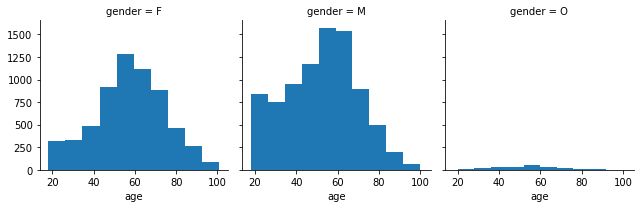

In [11]:
g1 = sns.FacetGrid(profile, col="gender")
g1 = g1.map(plt.hist, "age")

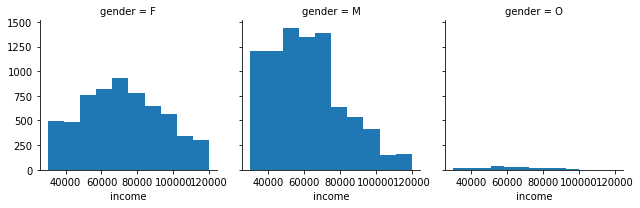

In [12]:
g2 = sns.FacetGrid(profile, col="gender")
g2 = g2.map(plt.hist, "income")

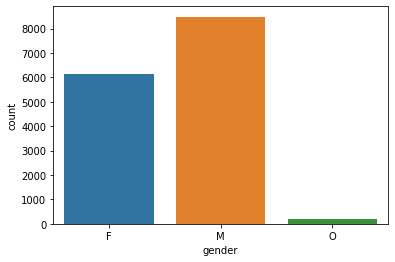

In [13]:
sns.countplot(x = 'gender', data = profile)

There are more male than female customers. There are the most customers in the 50-70 age bracket within both gender groups, but there are also a high number of under 50s males. As for income level, that of female customers is more evenly distributed but that of males are concentrated in the group <70000.

In [14]:
print('Earliest joining date: ', profile['became_member_on'].min())
print('Latest joining date: ', profile['became_member_on'].max())

Earliest joining date:  20130729
Latest joining date:  20180726


###### Transcript data

In [15]:
customised_fct.read_data(transcript)

There are 306534 entries
There are 4 columns
 
These are the data types --
event     object
person    object
time       int64
value     object
dtype: object
 
The columns have the following number of nulls
event     0
person    0
time      0
value     0
dtype: int64
 
 


,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [16]:
print('Max time: ', transcript['time'].max())

Max time:  714


In [17]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [18]:
print('types of events:')
transcript['event'].unique()

types of events:


array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

**Number of unique customers in transaction data**

In [19]:
len(set(transcript[transcript['event']=='offer received']['person']))

16994

**Number of unique control customers (who have not received offers if there are any at all)**

In [20]:
len(set(transcript[transcript['event']=='transaction']['person']) - \
    set(transcript[transcript['event']=='offer received']['person']))

6

In [21]:
len(set(profile['id']) - \
    set(transcript[transcript['event']=='offer received']['person']))

6

As seen from above control group is almost non-existent in the data (only 6 data points). More than 99% of the customers in the data have received offers.

In [22]:
# Examine the events of customer #1
transcript[transcript['person']=='78afa995795e4d85b5d9ceeca43f5fef']

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
15561,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
47582,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,{'amount': 19.89}
47583,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
49502,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,{'amount': 17.78}
53176,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
85291,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
87134,transaction,78afa995795e4d85b5d9ceeca43f5fef,222,{'amount': 19.67}
92104,transaction,78afa995795e4d85b5d9ceeca43f5fef,240,{'amount': 29.72}
141566,transaction,78afa995795e4d85b5d9ceeca43f5fef,378,{'amount': 23.93}


**Q: Why are some offers never 'completed' even though a transaction has occured after offer is sent and viewed?**

In [23]:
portfolio[portfolio['id']=='5a8bc65990b245e5a138643cd4eb9837']

,channels,difficulty,duration,id,offer_type,reward
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0


**Q:Are there any 'completed' informational offers?**

In [24]:
transcript[transcript['value'] == {'offer id':'5a8bc65990b245e5a138643cd4eb9837'}]['event'].value_counts()

offer received    7618
offer viewed      6687
Name: event, dtype: int64

In [25]:
transcript[transcript['value'] == {'offer id':'3f207df678b143eea3cee63160fa8bed'}]['event'].value_counts()

offer received    7617
offer viewed      4144
Name: event, dtype: int64

There isn't a single informational offer that is marked as 'completed in the data. It is potentially because it cannot be tracked.

In [26]:
# Examine the events of customer #2
transcript[transcript['person']=='a03223e636434f42ac4c3df47e8bac43']

,event,person,time,value
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
15562,offer viewed,a03223e636434f42ac4c3df47e8bac43,6,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
90553,transaction,a03223e636434f42ac4c3df47e8bac43,234,{'amount': 1.09}
97700,transaction,a03223e636434f42ac4c3df47e8bac43,264,{'amount': 3.5}
110829,offer received,a03223e636434f42ac4c3df47e8bac43,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
123539,offer viewed,a03223e636434f42ac4c3df47e8bac43,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
150599,offer received,a03223e636434f42ac4c3df47e8bac43,408,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
201573,offer received,a03223e636434f42ac4c3df47e8bac43,504,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
245125,offer received,a03223e636434f42ac4c3df47e8bac43,576,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
277104,transaction,a03223e636434f42ac4c3df47e8bac43,612,{'amount': 0.06}


**Q: Can a customer make two separate transactions in the same time frame?**

In [27]:
(transcript[transcript['event']=='transaction'][['person','time']].duplicated()).sum()

0

The following data entry rules are observed from the transcript data:
- Informational offers do not come with any rewards, hence they cannot be completed even when it has been viewed a transaction occurs within its duration.
- Offers do not have to be viewed to be completed.
- The data also contains transactions that are not associated with any offers.
- A single transaction can complete two offers.

### Direction of analysis

Uplift analysis will be conducted on the data, to understand the incremental likeliness to purchase after receiving and viewing an offer. The model will predict whether a customer make a purchase and how much more they are likely to pay (as compared to purchases not made with an offer) after receiving an offer, with demographics and offer details as features. 

## 2. Data Preprocessing

Before further analysis, we need to carry out steps to clean and transform the data. The goal is to get to a unique person-offer or person-transaction (if transaction is not linked to any offer) per line, with all customer and offer data combined on a single dataframe. These are some of the steps that I would do:
- Impute nulls
- Convert data types
- Transpose and summarise data
- Join datasets

**Assumptions in data cleansing**


- Each offer to each customer is treated independently, i.e. each row is a unique customer-offer-receipt time combination.
- A success is when an offer is completed within the effective duration after being viewed.
- In the current dataset, there are no completion flagged for information offer. However in the below, if a transaction occured after an informational offer is viewed, within the effective duration, it is attributed to the offer.
- If there are multiple offer completions (associated with a single transaction) with the same timestamp attributed a single type of offer per unique customer, it will be attributed to the last viewed and received offer.
- If an offer is not viewed before it is completed, then the transaction is not attributed to the offer. (not considered a success.

###### Portfolio data
Duration column will be converted to hours and channels column parsed and encoded.

In [7]:
dpreprocess = RawPreprocess()
portfolio_new = dpreprocess.portfoliodf_trans(portfolio)
portfolio_new.head()
portfolio_new.to_csv('portfolio_new.csv')

###### Profile data
Null profiles will be flagged on a separate row and their demographic values will be imputed with mean.

In [8]:
profile_new = dpreprocess.profiledf_clean(profile)
profile_new.head()
profile_new.to_csv('profile_new.csv')

###### Transcript data
The data will be transposed such that one offer is on one row, showing whether the offer has been received, viewed, transacted and completed

In [30]:
transcript_parsed = dpreprocess.parse_order_id(transcript)
transcript_parsed.head()

,event,person,time,amount,clean_offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,,4d5c57ea9a6940dd891ad53e9dbe8da0


In [31]:
# How many offer id's are under the 'offer_id' column?
(transcript['offer_id'].apply(lambda x:len(x))>1).sum()

33579

In [32]:
# Merge portfolio and transcript data
transcript_portfolio = transcript_parsed.merge(portfolio_new, how = 'outer', left_on = ['clean_offer_id'], \
                                        right_on = ['id']).drop('id', axis = 1)

transcript_final, unmatch_trans_final = dpreprocess.transpose_transcript(transcript_portfolio)

# Merge transcript/portfolio data with profile data
all_data_merge = transcript_final.merge(profile_new, left_on = ['person'], right_on = ['id'])

all_data_merge = all_data_merge.drop(['effect_timeout', 'id'], axis = 1)

View data joined!
Number of duplicated time_view rows: 21604
Duplicated time_view eliminated!
 
Completed data joined!
Number of completed offers on records:  33182
Number of viewed AND completed offers: (only these are joined into the df)  23496
 
Transaction data joined!
Number of transactions that do not join: 116393
 
Completed info offer timestamps joined!
Number of completed offers:  29272
Number of transactions not prompted by offers:  110617


In [33]:
data_final = dpreprocess.add_prior_col(all_data_merge, unmatch_trans_final)
data_final = dpreprocess.feature_create(data_final)
data_final.head()

,person,clean_offer_id,time_rec,difficulty,offer_type,reward,duration_h,web,email,mobile,...,gender_O,num_purch_prior,avg_purch_amt_prior,num_rec_prior,num_view_prior,num_comp_prior,success,percent_view_prior,percent_comp_prior,freq_purch_prior
0,5265f933778d4350b21b2199f432521d,5a8bc65990b245e5a138643cd4eb9837,576.0,0.0,informational,0.0,72.0,0.0,1.0,1.0,...,0,5.0,26.010000,3.0,2.0,2.0,0,0.666667,0.666667,115.2
1,5265f933778d4350b21b2199f432521d,9b98b8c7a33c4b65b9aebfe6a799e6d9,408.0,5.0,bogo,5.0,168.0,1.0,1.0,1.0,...,0,5.0,26.010000,2.0,2.0,2.0,0,1.000000,1.000000,81.6
2,5265f933778d4350b21b2199f432521d,fafdcd668e3743c1bb461111dcafc2a4,168.0,10.0,discount,2.0,240.0,1.0,1.0,1.0,...,0,3.0,23.496667,1.0,1.0,1.0,1,1.000000,1.000000,56.0
3,5265f933778d4350b21b2199f432521d,ae264e3637204a6fb9bb56bc8210ddfd,0.0,10.0,bogo,10.0,168.0,0.0,1.0,1.0,...,0,0.0,0.000000,0.0,0.0,0.0,1,0.000000,0.000000,0.0
4,345f9431137a49b3963221a55567c4a8,0b1e1539f2cc45b7b9fa7c272da2e1d7,576.0,20.0,discount,5.0,240.0,1.0,1.0,0.0,...,0,3.0,21.280000,4.0,3.0,2.0,0,0.750000,0.500000,192.0


In [34]:
data_final.head()


,person,clean_offer_id,time_rec,difficulty,offer_type,reward,duration_h,web,email,mobile,...,gender_O,num_purch_prior,avg_purch_amt_prior,num_rec_prior,num_view_prior,num_comp_prior,success,percent_view_prior,percent_comp_prior,freq_purch_prior
0,5265f933778d4350b21b2199f432521d,5a8bc65990b245e5a138643cd4eb9837,576.0,0.0,informational,0.0,72.0,0.0,1.0,1.0,...,0,5.0,26.010000,3.0,2.0,2.0,0,0.666667,0.666667,115.2
1,5265f933778d4350b21b2199f432521d,9b98b8c7a33c4b65b9aebfe6a799e6d9,408.0,5.0,bogo,5.0,168.0,1.0,1.0,1.0,...,0,5.0,26.010000,2.0,2.0,2.0,0,1.000000,1.000000,81.6
2,5265f933778d4350b21b2199f432521d,fafdcd668e3743c1bb461111dcafc2a4,168.0,10.0,discount,2.0,240.0,1.0,1.0,1.0,...,0,3.0,23.496667,1.0,1.0,1.0,1,1.000000,1.000000,56.0
3,5265f933778d4350b21b2199f432521d,ae264e3637204a6fb9bb56bc8210ddfd,0.0,10.0,bogo,10.0,168.0,0.0,1.0,1.0,...,0,0.0,0.000000,0.0,0.0,0.0,1,0.000000,0.000000,0.0
4,345f9431137a49b3963221a55567c4a8,0b1e1539f2cc45b7b9fa7c272da2e1d7,576.0,20.0,discount,5.0,240.0,1.0,1.0,0.0,...,0,3.0,21.280000,4.0,3.0,2.0,0,0.750000,0.500000,192.0


In [35]:
# Saving cleaned dataframe so that data cleansing steps do not have to be run again
data_final.to_csv('data_final.csv')
unmatch_trans_final.to_csv('unmatch_trans_final.csv')

In [36]:
data_final.dtypes

person                  object
clean_offer_id          object
time_rec               float64
difficulty             float64
offer_type              object
reward                 float64
duration_h             float64
web                    float64
email                  float64
mobile                 float64
social                 float64
time_view              float64
time_comp              float64
amount                 float64
time_trans             float64
age                    float64
income                 float64
null_info                int64
days_joined              int64
gender_F                 uint8
gender_M                 uint8
gender_O                 uint8
num_purch_prior        float64
avg_purch_amt_prior    float64
num_rec_prior          float64
num_view_prior         float64
num_comp_prior         float64
success                  int64
percent_view_prior     float64
percent_comp_prior     float64
freq_purch_prior       float64
dtype: object

## 3. Treatment groups balancing

#### Further EDA
Now that the data has been cleaned, more EDA can be carried out to understand relationship between variables and the distribution of covariates between treatment groups. This would determine whether and how to balance the samples amongst treatment groups.

**Q1. What is the success rate of different offer types?**

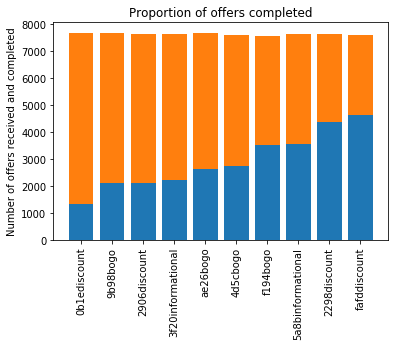

In [37]:
success_plot = data_final.groupby(['clean_offer_id', 'offer_type']).agg({'success' : ['sum', 'size']})\
               .reset_index().sort_values(by = [('success','sum')])
success_plot['diff'] = success_plot[('success','size')] - success_plot[('success','sum')]

x_labels = success_plot['clean_offer_id'].apply(lambda x:x[:4]) + success_plot['offer_type']
p1 = plt.bar(x_labels, success_plot[('success','sum')])
p2 = plt.bar(x_labels, success_plot['diff'], bottom = success_plot[('success','sum')])
plt.ylabel('Number of offers received and completed')
plt.title('Proportion of offers completed')
plt.xticks(rotation = 90)
plt.show()

- Across all offer types, those that are distributed via social media have the highest completion rate. 
- The offers with the highest completion rates are discounts that are distributed across four communication channels. Coming third is an informational offer, followed by buy-one-get-one offers.
- The completion rate range from around 12% to more than 50%.**

**Q2. What is the average revenue for a completed offer?**

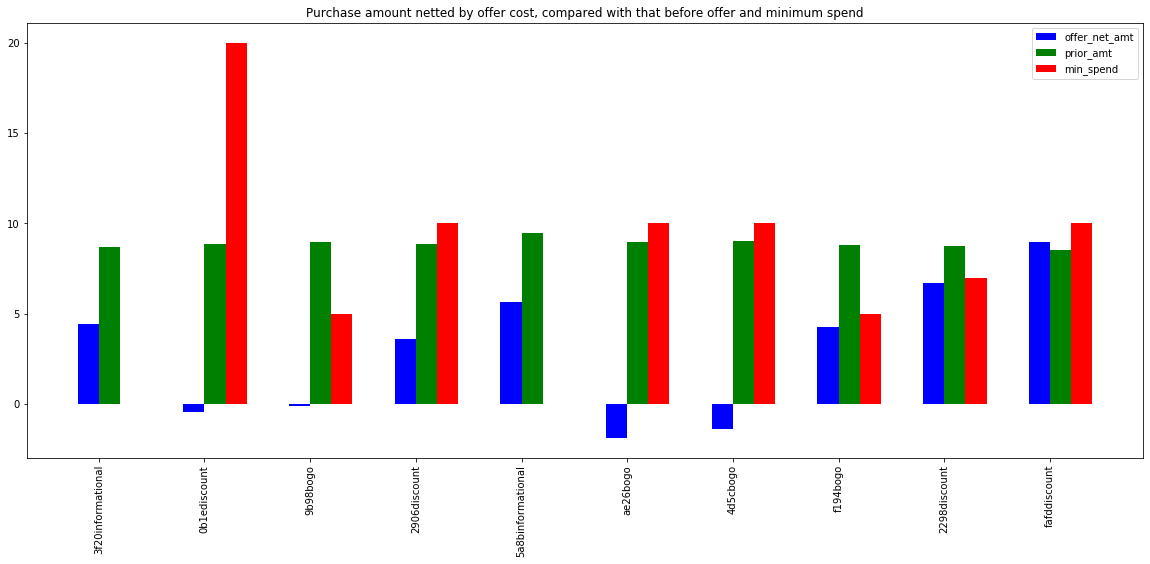

In [38]:
avg_rev_plot = data_final.groupby(['clean_offer_id', 'offer_type', 'difficulty', 'reward'])[['amount', 'avg_purch_amt_prior']]\
               .mean().reset_index().sort_values(by='amount')

plt.figure(figsize = (20,8))

labels = avg_rev_plot['clean_offer_id'].apply(lambda x:x[:4]) + avg_rev_plot['offer_type']
y = avg_rev_plot['amount'] - avg_rev_plot['reward']
z = avg_rev_plot['avg_purch_amt_prior']
k = avg_rev_plot['difficulty']
width = 0.2 

ax = plt.subplot()
ax.bar(np.arange(len(avg_rev_plot)) - width/2, y, width=width, color='b', align='center', label = 'offer_net_amt')
ax.bar(np.arange(len(avg_rev_plot)) + width/2, z, width=width, color='g', align='center', label = 'prior_amt')
ax.bar(np.arange(len(avg_rev_plot)) + width*3/2, k, width=width, color='r', align='center', label = 'min_spend')

plt.title('Purchase amount netted by offer cost, compared with that before offer and minimum spend')
ax.set_xticks(np.arange(len(avg_rev_plot)))
ax.set_xticklabels(labels)
plt.xticks(rotation = 90)
ax.legend()

plt.show()

- The net revenue, which is calculated by subtracting reward from purchase amount, is incrementally higher than the revenue for purchases not prompted by offers, except for one informational offer. In the treatment group of this informational offer, the average amount spent prior to offers is slightly higher than other treatment groups, which might explain why it effect is an incremental decrease.
- As most bogo and discount offers have a minimum spend of below 10 dollars, which is lower than the average amount spent prior to offers, the incremental net revenue of these offers are limited to 0 - 5 dollars. The only one offer with a minimum spend of 20 dollars, however, encouraged customers to make ~8 dollar incremental purchase to be eligible for the offer.
- Discounts yield the highest incremental net revenue compared to bogo and informational offers. 
- Surprisingly, the '3f20' informational offer yields a similar net revenue increment as the 'f194' bogo offer despite having no rewards.

**Q3: What is the demographic distribution of those in different treatment groups?** (assuming each offer id - user is unique)

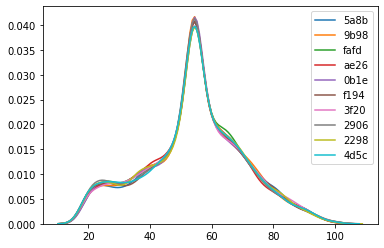

In [10]:
EDAplot_fct = EDAplot()
EDAplot_fct.treatment_dist_plot(df = data_final, var = 'age')

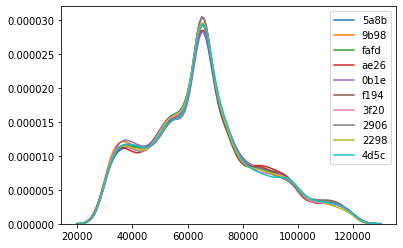

In [40]:
EDAplot_fct.treatment_dist_plot(data_final, 'income')

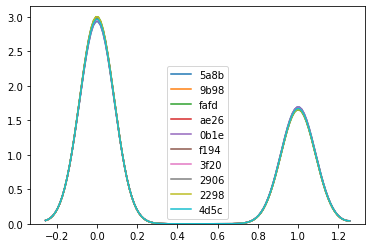

In [41]:
EDAplot_fct.treatment_dist_plot(data_final, 'gender_F')

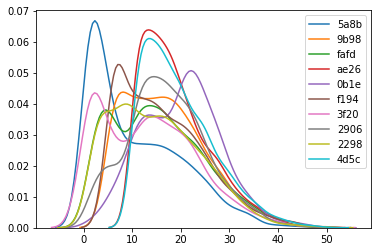

In [42]:
EDAplot_fct.treatment_dist_plot(data_final, 'amount', lim = (0, 50))

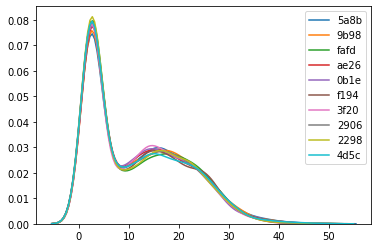

In [43]:
EDAplot_fct.treatment_dist_plot(data_final, 'avg_purch_amt_prior', lim = (0, 50))

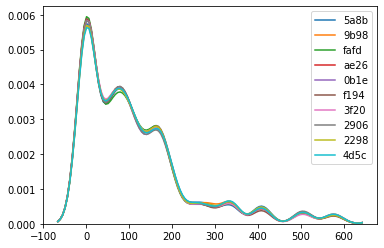

In [44]:
EDAplot_fct.treatment_dist_plot(data_final, 'freq_purch_prior')

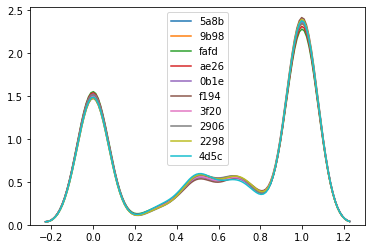

In [45]:
EDAplot_fct.treatment_dist_plot(data_final, 'percent_view_prior')

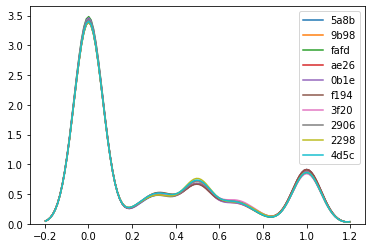

In [46]:
EDAplot_fct.treatment_dist_plot(data_final, 'percent_comp_prior')

**From the above plots, we can confirm that the targets for each treatment group are randomised - their demographic distribution (age, gender, income) and behavioural metric distribution (average amount of purchases that are not prompted by offers) are similar despite not being normally distributed. Hence, there is no need for any balancing, for instance, propensity score matching, before identifying the average and individual treatment effect.**

What is the difference in uplift between different demographic groups?

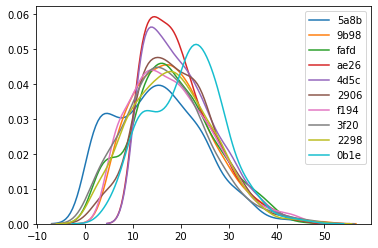

In [16]:
gender_col = ['gender_F', 'gender_M']

EDAplot_fct.treatment_dist_plot(data_final.loc[data_final[gender_col[0]]==1], 'amount', lim = (0, 50))

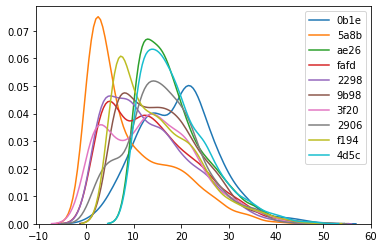

In [17]:
EDAplot_fct.treatment_dist_plot(data_final.loc[data_final[gender_col[1]]==1], 'amount', lim = (0, 50))

Males are likely to spend just above the minimum spend required than females, who spend on average 15 dollars on most offers.

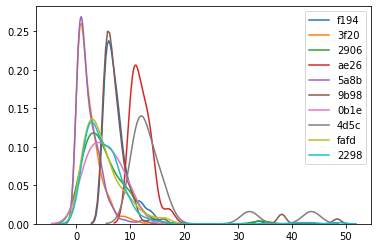

In [32]:
EDAplot_fct.treatment_dist_plot(data_final.loc[data_final['null_info']==1], 'amount', lim = (0, 50))

Those who do not enter any personal details almost only spend below 20 dollars and only spend just enough to meet the minimum requirement for offer redemption.

**What is the difference in uplift between income groups?**

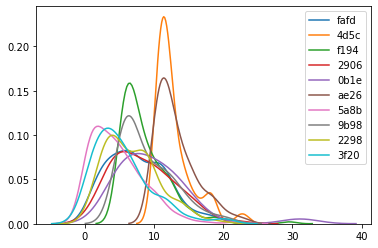

In [18]:
EDAplot_fct.treatment_dist_plot(data_final.loc[data_final['income']<35000], 'amount', lim = (0, 50))

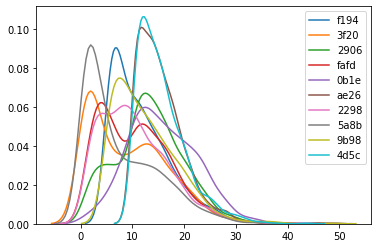

In [28]:
EDAplot_fct.treatment_dist_plot(data_final.loc[(data_final['income']>35000) & (data_final['income']<70000)],
                                'amount', lim = (0,50))

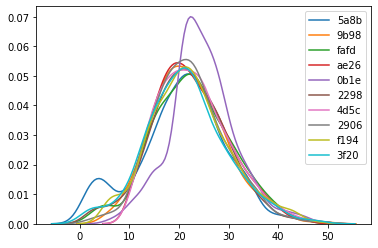

In [29]:
EDAplot_fct.treatment_dist_plot(data_final.loc[(data_final['income']>=70000)],
                                'amount', lim = (0,50))

Those with lower income are likely to spend just above the minimum spend required than those earning more. For example, those redeeming '4d5c' and 'ae26' in the <35000 income group are spending just slightly above 10 dollars. More of those who earn between 35000-70000 spend above 15 dollars for these two offers. For those earning above 70000, their mean spend is 20 regardless of which offer they are redeeming.


**What is the difference in spend (due to offer redemption) between groups joined at different date?**

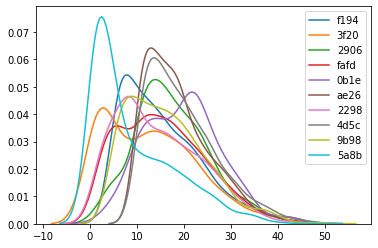

In [37]:
EDAplot_fct.treatment_dist_plot(data_final.loc[(data_final['days_joined']<=365)],
                                'amount', lim = (0,50))

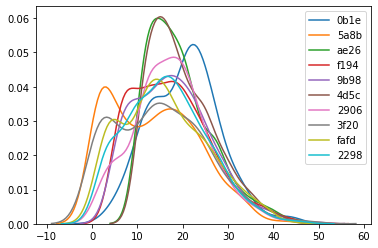

In [41]:
EDAplot_fct.treatment_dist_plot(data_final.loc[(data_final['days_joined']>365)&(data_final['days_joined']<730)],
                                'amount', lim = (0,50))

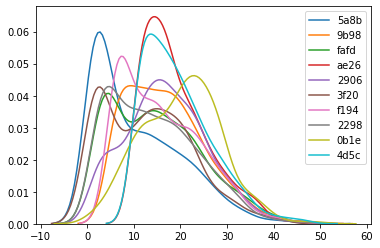

In [42]:
EDAplot_fct.treatment_dist_plot(data_final.loc[(data_final['days_joined']>730)],
                                'amount', lim = (0,50))

There is no specific offer spend patterns between those who joined recently (recent one year) and those who joined earlier than those who join later.



## 4. Data Analysis and Modelling

In this section, we will find out which offers are the most effective overall, and which offers are particularly effective for particular types of customers.

### 4a. Average effect of offers

In the above EDA, the visualisations have informed the overall offer completion rate and net revenue increment of the whole treatment group. This is not very accurate as not all treatment targets are actually exposed (have viewed) the offer. In other words, each treatment group contains a subset that is not affected by the offer because they do not see them. (It could be because of reasons like they didn't log into the Starbucks app, their email or social media account) The subset who viewed the offer is not a random sample. They are a self selected group of customers who decided to engage with Starbucks promotional offers for a variety of reasons.

In this section, we will calculate, the % of customers who completed each offer out of all those who viewed it, as well as their purchase amount, netted by the reward amount (which equals to the amount that actually comes out of their pockets). As there is no control group in the dataset, these metrics will be compared to the engaged users' historical behaviour (for easier matching) - have they made any purchases that is not in response to an offer prior to receiving the said offer, and if so what is the average purchase amount.

In [5]:
data_final = pd.read_csv('data_final.csv')

In [6]:
TreatmentModel = TreatmentModelling(df = data_final)
lift_df = TreatmentModel.calc_lift(df = data_final)
lift_df

/Users/hyap1/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/hyap1/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,offer,prob_comp,expected_uplift
2,fafdcd668e3743c1bb461111dcafc2a4,0.610109,4.577344
8,2298d6c36e964ae4a3e7e9706d1fb8c2,0.572456,2.978727
5,f19421c1d4aa40978ebb69ca19b0e20d,0.467045,2.926441
7,2906b810c7d4411798c6938adc9daaa5,0.278826,2.345130
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.173709,1.995961
3,ae264e3637204a6fb9bb56bc8210ddfd,0.341212,1.810916
9,4d5c57ea9a6940dd891ad53e9dbe8da0,0.362307,1.778862
6,3f207df678b143eea3cee63160fa8bed,0.289878,1.644227
0,5a8bc65990b245e5a138643cd4eb9837,0.468364,1.452345
1,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.276671,0.854332


As seen from the above results, most offers yield an uplift in net revenue amongst customers who actually viewed the offer. It is likely encouraged by the minimum spend (difficulty level).

However, amongst those who viewed the offer (affected by the offer), the percentage of those who completed the offer is lower than the percentage of those who has made a purchase before. In this context, it doesn't mean that the offer has a negative impact on the probability of purchases. It could be that customers have recently bought a coffee with another offer or without an offer, hence not responding to the particular offer in question at the time.

### 4b. Identify which offers are more effective for different subset of customers

To do so, we will run three models. 
1. A classification model will be fit onto the data to predict whether a customer would complete an offer. Features for prediction would include the type of offer received, the customer demographics and behavioural metrics and interaction between the two.
2. Regression models will be fit onto the data with success flag. One regression model will be fitted for purchases associated with each offer as distribution of purchase amount varies amongst offers.
3. A single regression model will be fit onto purchase data that is not associated with any offers.

The logic is as follows:

\begin{equation*}
P(success) = P(viewed) * P(completed)\\
Net Revenue Uplift(per order) = Revenue with offer - Difficulty - Revenue without Offer\\
Expected Uplift(per order) = P(success) * Net Revenue Uplift\\
\end{equation*}

**Predict whether a customer is likely to complete an offer**

Ensemble methods like Random Forest, Gradient Boosting, as well as Logistics model will be fitted onto the data to compare results. After choosing the one, I will carry out hyper-parameter tuning.

In [55]:
dpreprocess = RawPreprocess()

In [56]:
y = data_final[['success', 'amount']]
X = data_final[['clean_offer_id', 'age', 'income', 'null_info', 'days_joined', 'gender_F', 'gender_M', 
               'gender_O', 'freq_purch_prior', 'avg_purch_amt_prior', 'num_rec_prior', 'percent_view_prior',
               'percent_comp_prior']]

X_interact, X_interact_col_define = dpreprocess.create_interaction(X, 'clean_offer_id')
X_interact.head()

,age,income,null_info,days_joined,gender_F,gender_M,gender_O,freq_purch_prior,avg_purch_amt_prior,num_rec_prior,...,null_info_fafd,days_joined_fafd,gender_F_fafd,gender_M_fafd,gender_O_fafd,freq_purch_prior_fafd,avg_purch_amt_prior_fafd,num_rec_prior_fafd,percent_view_prior_fafd,percent_comp_prior_fafd
0,61.0,83000.0,0,799,1,0,0,115.2,26.010000,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,61.0,83000.0,0,799,1,0,0,81.6,26.010000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,61.0,83000.0,0,799,1,0,0,56.0,23.496667,1.0,...,0.0,799.0,1.0,0.0,0.0,56.0,23.496667,1.0,1.0,1.0
3,61.0,83000.0,0,799,1,0,0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,53.0,77000.0,0,477,0,1,0,192.0,21.280000,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [57]:
y.head()

,success,amount
0,0,0.00
1,0,0.00
2,1,10.95
3,1,21.77
4,0,0.00


In [60]:
RFC = RandomForestClassifier(random_state = 42)
GBC = GradientBoostingClassifier()
Logit = LogisticRegression()
XGBClass = XGBClassifier()

class_model_list = [RFC, GBC, Logit, XGBClass]
class_results = TreatmentModel.choose_model(X_interact, y['success'], class_model_list, 'class')

Model_short ['RandomForestCla', 'GradientBoostin', 'LogisticRegress', 'XGBClassifier(b']
Test Precision [0.6431163287086447, 0.6991069384016487, 0.6588821831540278, 0.6974692361272348]
Train Precision [0.9922797053864584, 0.7052154195011338, 0.6661122937732836, 0.7063391624482283]
Test Recall [0.5130257108802997, 0.519836540098757, 0.42754980418865995, 0.5114932743061468]
Train recall [0.9557673404846361, 0.5316466515663063, 0.42792427026796015, 0.5247660156416941]
Test ROC AUC [0.6674155518059177, 0.6898980206621889, 0.6445006827614941, 0.6863125542371616]
Train ROC AUC [0.9755711934999864, 0.6967148254376108, 0.6472591422043112, 0.6945370666162328]



**Evaluation**

Out of all different types of models, Gradient Boosting perform the best in terms of precision (0.70), ROC AUC score (0.69) on the test set and on recall (0.53) on the test set. Their test score are on very close to their train score, which means there is little overfitting issue. 

XGBoost, another form of gradient boosting model, perform the second best overall in terms of precision (0.70), ROC AUC (0.69) and on recall (0.52) on the test set. There is also no overfitting issue.

Random Forest comes third in terms of precision (0.63), ROC AUC (0.66) and the best on recall (0.51) on the test set. Nevertheless they have more serious overfitting issue, with the training scores all around 0.97. This is a common issue for random forest model unless their depth is being controlled.

Last but not least, Logistics Regression performs the worst in terms of all three scoring, especially on recall. This is possibly because of the imbalance in classes and the non linearity of relationships.

In light of all the above, XGBoost with optimised hyperparameters will be used to predict whether a customer is likely to complete an offer for the following reasons:
- Randomised feature selection and regularisation reduces overfitting but still results in relatively high precision and recall scores
- Quicker model training speed compared with all other models
- Doesn't assume linearity of variables as logistics regression does

There are still the following limitations:
- Results could be difficult to interpret as it is a non-parametric model. 
- Lower recall than precision, meaning that nearly half of the positives (offer completions) are being classified as negatives, yet fewer negatives (non-completed offers) are being wrongly classified as positives. This problem exist across all models and re-sampling techniques might be required to address such class imbalance.

In [61]:
XGBClass = XGBClassifier()

XGBParams = {'booster': ['gbtree', 'dart'],
            'sample': [0.75, 1],
            'lambda': [0.8, 1, 1.2]}

XGBClass_gsresults = TreatmentModel.gridsearch_pipelines(
                        X_interact, y['success'], XGBClass, XGBParams, 
                        scoring_list = ['f1', 'precision', 'recall', 'roc_auc'], refit_score = 'f1')

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   53.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  25 out of  36 | elapsed:  3.5min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  29 out of  36 | elapsed:  3.7min remaining:   53.0s
[Parallel(n_jobs=-1)]: Done  33 out of  36 | elapsed:  4.1min remaining:   22.3s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  4.1min finished


Best Estimator of  XGBClassif  : {'booster': 'gbtree', 'lambda': 0.8, 'sample': 0.75}
Best refit test score 0.5855555696636432
Mean test scores
mean_test_f1 0.5855555696636433
mean_test_precision 0.6932141160246389
mean_test_recall 0.5081646718845525
mean_test_roc_auc 0.7852466429072257
mean_train_f1 0.6015396465933727
mean_train_precision 0.7053412987950297
mean_train_recall 0.5243750579512593
mean_train_roc_auc 0.8001470601133428
 


In [62]:
final_classifier = XGBClass_gsresults['best_estimator'][0]
print(final_classifier)
success_classifier = TreatmentModel.train_model(X_interact, y['success'], final_classifier, 'class')
print('Model trained!')

TreatmentModel.export_model(success_classifier, 'success_classifier.pkl')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, lambda=0.8,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, sample=0.75, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)
Test Precision 0.7064027939464493
Train Precision 0.7035448827901658
Test Recall 0.5179242062137248
Train recall 0.5255402750491159
Test ROC AUC 0.6918733608212697
Train ROC AUC 0.6938335033872962
Model trained!


**Predict spend amount for different offers**

Before using this approach, I have experimented with multiple other models, one of which is modelled across all successfully completed offer. However, both the R2 and the MSE had performed poorly as the minimum spend (difficulty level) of each offer results in a different distribution of spend.

As a result, I have created separate models for the predicted spend of completing each offer as follows. Using this approach, I wouldn't need any dummy predictors flagging up which offer was given, or interaction terms between the offer and demographic variables. 

In addition, as the spend distribution is skewed to the right, there is a long tail of high spenders. For example, there could be a customer making a 900 dollar purchase in one visit, which is very uncommon. To eliminate these outliers, I have removed values above the 90th percentile.

I would also test the model on a number of algorithms like XGBoost (from which I can choose models that fit skewed distributions), Random Forest, Linear Regression and L2 Linear Regression (Ridge).

In [64]:
X_offer_90 = np.percentile(data_final.loc[~np.isnan(data_final['amount']), 'amount'], 90)
success_idx = y.loc[(y['success']==1) & (y['amount']<X_offer_90)].index
data_reg = data_final.loc[success_idx]
y_col = ['amount']
X_col = ['age', 'income', 'null_info', 'days_joined', 'gender_F', 'gender_M', 
        'gender_O', 'freq_purch_prior', 'avg_purch_amt_prior', 'num_rec_prior', 
        'percent_view_prior', 'percent_comp_prior']
reg_model_list = [XGBRegressor(objective = 'reg:gamma'), 
                 RandomForestRegressor(random_state = 42),
                 LinearRegression(),
                 Ridge()]
reg_results = {}

for offer in data_final['clean_offer_id'].unique():
    print(offer)
    offer_df_reg = data_reg.loc[(data_reg['clean_offer_id']==offer)]
    X_reg = offer_df_reg[X_col]
    y_reg = offer_df_reg[y_col]

    reg_results[offer[:4]] = TreatmentModel.choose_model(X_reg, y_reg, reg_model_list, 'reg')
    

5a8bc65990b245e5a138643cd4eb9837
Model_short ['XGBRegressor(ba', 'RandomForestReg', 'LinearRegressio', 'Ridge(alpha=1.0']
Test MSE [14.394566098631461, 15.161174655629141, 21.54214090868841, 21.536665472542648]
Train MSE [12.930605764750474, 3.1110438127589064, 24.212763098897053, 24.212937962986896]
Test R2 [0.643762446956365, 0.6247903741188845, 0.4668738528101969, 0.4670093592201191]
Train R2 [0.6978331755818652, 0.9273000626088468, 0.43418785870597587, 0.4341837724220311]

9b98b8c7a33c4b65b9aebfe6a799e6d9
Model_short ['XGBRegressor(ba', 'RandomForestReg', 'LinearRegressio', 'Ridge(alpha=1.0']
Test MSE [11.42705263530451, 13.014286890675242, 12.569462552362516, 12.575199765280614]
Train MSE [11.428969550921092, 2.968511750803858, 16.457378803716445, 16.45770243235026]
Test R2 [0.5173938168577583, 0.45035911506856197, 0.4691456721041556, 0.4689033686409052]
Train R2 [0.5436553363842063, 0.8814709856103395, 0.34287715434726973, 0.3428642322549168]

fafdcd668e3743c1bb461111dcafc2a4
Mod

**Evaluation**
XGBoost Regressor performs consistently better across different models for different offers - highest training R score and lower MSE. The test R2 range from 0.14 to 0.64, with most of the R2 scored at around 0.55. It means that around 55% of the variation in the spend can be explained by regressors. It is likely because the regression assumes gamma distribution, which better suit the distribution of the spend results. The models for some offers are less well fitted because their distribution do not follow a gamma distribution (usually slightly bimodal skewed).

Linear and Ridge yield worse results. Both have similar performance with less overfitting. Random Forest have the worst test score with serious overfitting problems.

In light of the above, XGBoost Regressor would be chosen for the model below for reasons very similar to why XGBoost Classifier was chosen above.

In [65]:
XGBRegParams = {'objective': ['reg:squarederror', 'reg:gamma', 'reg:tweedie'],
                'booster': ['gbtree', 'dart'],
                'subsample': [0.75, 1],
                'lambda': [0.8, 1, 1.2]}
XGBReg_gsresults = {}

for offer in data_final['clean_offer_id'].unique():
    print(offer)
    offer_df_reg = data_reg.loc[(data_reg['clean_offer_id']==offer)]
    X_reg = offer_df_reg[X_col]
    y_reg = offer_df_reg[y_col]

    XGBReg_gsresults[offer[:4]] = TreatmentModel.gridsearch_pipelines(
                                  X_reg, y_reg, XGBRegressor(), XGBRegParams, 
                                  scoring_list = ['r2', 'neg_mean_squared_error'], 
                                  refit_score = 'neg_mean_squared_error')
    
    final_offer_regressor = XGBReg_gsresults[offer[:4]]['best_estimator'][0]
    success_regressor = TreatmentModel.train_model(X_reg, y_reg, final_offer_regressor, 'reg')
    
    print('Best model being trained and exported...')
    TreatmentModel.export_model(success_regressor, 'success_regressor_'+offer[:4]+'.pkl')
    print('Done!')
    print(' ')

5a8bc65990b245e5a138643cd4eb9837
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 104 out of 108 | elapsed:    4.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    4.9s finished


Best Estimator of  XGBRegress  : {'booster': 'gbtree', 'lambda': 0.8, 'objective': 'reg:tweedie', 'subsample': 0.75}
Best refit test score -15.021799204743822
Mean test scores
mean_test_r2 0.6383516137681943
mean_test_neg_mean_squared_error -15.146691784998662
mean_train_r2 0.716243231683573
mean_train_neg_mean_squared_error -11.973301605204428
 
Test MSE 13.373625162737829
Train MSE 12.2177745275517
Test R2 0.6727563880266849
Train R2 0.7136725016382596
Best model being trained and exported...
Done!
 
9b98b8c7a33c4b65b9aebfe6a799e6d9
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1201s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  82 out of 108 | elapsed:    2.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done 104 out of 108 | elapsed:    3.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    3.1s finished


Best Estimator of  XGBRegress  : {'booster': 'gbtree', 'lambda': 0.8, 'objective': 'reg:gamma', 'subsample': 0.75}
Best refit test score -14.124917655579358
Mean test scores
mean_test_r2 0.4198648677086163
mean_test_neg_mean_squared_error -14.269482369550524
mean_train_r2 0.6045978041094838
mean_train_neg_mean_squared_error -9.779039338398901
 
Test MSE 14.194299672050521
Train MSE 10.763322219346831
Test R2 0.41062084917988617
Train R2 0.5680986935798273
Best model being trained and exported...
Done!
 
fafdcd668e3743c1bb461111dcafc2a4
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 104 out of 108 | elapsed:    6.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    6.2s finished


Best Estimator of  XGBRegress  : {'booster': 'dart', 'lambda': 0.8, 'objective': 'reg:tweedie', 'subsample': 0.75}
Best refit test score -15.491701734885588
Mean test scores
mean_test_r2 0.5695622994614007
mean_test_neg_mean_squared_error -15.542214323530876
mean_train_r2 0.6443648093231419
mean_train_neg_mean_squared_error -12.925019772952934
 
Test MSE 17.2775476044543
Train MSE 12.790585610200129
Test R2 0.5497695835964602
Train R2 0.6437505497668625
Best model being trained and exported...
Done!
 
ae264e3637204a6fb9bb56bc8210ddfd
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1294s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  82 out of 108 | elapsed:    2.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done 104 out of 108 | elapsed:    3.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    3.2s finished


Best Estimator of  XGBRegress  : {'booster': 'dart', 'lambda': 0.8, 'objective': 'reg:gamma', 'subsample': 0.75}
Best refit test score -9.388581064736426
Mean test scores
mean_test_r2 0.17382641257461856
mean_test_neg_mean_squared_error -9.46613585031
mean_train_r2 0.3967812425352926
mean_train_neg_mean_squared_error -6.918092120275046
 
Test MSE 9.386178677913026
Train MSE 7.354044627019268
Test R2 0.2041859125714628
Train R2 0.35409305767298627
Best model being trained and exported...
Done!
 
0b1e1539f2cc45b7b9fa7c272da2e1d7
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0604s.) Setting batch_size=6.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best Estimator of  XGBRegress  : {'booster': 'gbtree', 'lambda': 0.8, 'objective': 'reg:tweedie', 'subsample': 1}
Best refit test score -16.200871538713873
Mean test scores
mean_test_r2 0.33859424424153184
mean_test_neg_mean_squared_error -16.32445419177083
mean_train_r2 0.6611728502202769
mean_train_neg_mean_squared_error -8.434978777622094
 
Test MSE 21.327688842069108
Train MSE 7.99195932187347
Test R2 0.24361775829037668
Train R2 0.6685336079475861
Best model being trained and exported...
Done!
 
f19421c1d4aa40978ebb69ca19b0e20d
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 104 out of 108 | elapsed:    4.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    4.9s finished


Best Estimator of  XGBRegress  : {'booster': 'gbtree', 'lambda': 0.8, 'objective': 'reg:gamma', 'subsample': 0.75}
Best refit test score -12.717317135301789
Mean test scores
mean_test_r2 0.48761487203708587
mean_test_neg_mean_squared_error -12.857614243418062
mean_train_r2 0.5984332390249749
mean_train_neg_mean_squared_error -10.080088426554141
 
Test MSE 11.615657138069164
Train MSE 10.95976318881329
Test R2 0.5355250395020592
Train R2 0.5630355682931273
Best model being trained and exported...
Done!
 
3f207df678b143eea3cee63160fa8bed
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1376s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  82 out of 108 | elapsed:    2.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done 104 out of 108 | elapsed:    3.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    3.4s finished


Best Estimator of  XGBRegress  : {'booster': 'gbtree', 'lambda': 0.8, 'objective': 'reg:squarederror', 'subsample': 0.75}
Best refit test score -16.304311453386653
Mean test scores
mean_test_r2 0.6309731564933697
mean_test_neg_mean_squared_error -16.810355423435993
mean_train_r2 0.7539720407028631
mean_train_neg_mean_squared_error -11.232112468645523
 
Test MSE 14.774816158598293
Train MSE 11.505021169948225
Test R2 0.6902016143051671
Train R2 0.7455277471386683
Best model being trained and exported...
Done!
 
2906b810c7d4411798c6938adc9daaa5
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1241s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  82 out of 108 | elapsed:    2.2s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done 104 out of 108 | elapsed:    3.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    3.0s finished


Best Estimator of  XGBRegress  : {'booster': 'dart', 'lambda': 0.8, 'objective': 'reg:gamma', 'subsample': 1}
Best refit test score -14.105186594354477
Mean test scores
mean_test_r2 0.49902124152451904
mean_test_neg_mean_squared_error -14.382920691979974
mean_train_r2 0.6786637936121522
mean_train_neg_mean_squared_error -9.440338119859812
 
Test MSE 13.290491910879714
Train MSE 10.565218762968856
Test R2 0.5565450702820671
Train R2 0.6412799468595394
Best model being trained and exported...
Done!
 
2298d6c36e964ae4a3e7e9706d1fb8c2
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 104 out of 108 | elapsed:    6.0s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    6.1s finished


Best Estimator of  XGBRegress  : {'booster': 'gbtree', 'lambda': 0.8, 'objective': 'reg:gamma', 'subsample': 1}
Best refit test score -14.561184030483798
Mean test scores
mean_test_r2 0.5856009057646313
mean_test_neg_mean_squared_error -14.626146837655341
mean_train_r2 0.668032715933988
mean_train_neg_mean_squared_error -11.796468344872368
 
Test MSE 13.503930963564237
Train MSE 12.693954997835952
Test R2 0.616605582272622
Train R2 0.6442074406083655
Best model being trained and exported...
Done!
 
4d5c57ea9a6940dd891ad53e9dbe8da0
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1324s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done  82 out of 108 | elapsed:    2.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done 104 out of 108 | elapsed:    3.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:    3.3s finished


Best Estimator of  XGBRegress  : {'booster': 'dart', 'lambda': 0.8, 'objective': 'reg:gamma', 'subsample': 1}
Best refit test score -9.194525814166846
Mean test scores
mean_test_r2 0.16766932495974018
mean_test_neg_mean_squared_error -9.327813912518884
mean_train_r2 0.40815954585267955
mean_train_neg_mean_squared_error -6.658626566301943
 
Test MSE 9.012610324940916
Train MSE 7.29281295199169
Test R2 0.2193822672167084
Train R2 0.3480028690946897
Best model being trained and exported...
Done!
 


### Predict spend without offer

For this regression model, only demographic variables are used as regressors, to keep it general and independent of historic behavioural variables that are related to offer redemption. A simple model as such would be sufficient for a baseline upon which uplift revenue can be caluclated.

In [66]:
unmatch_trans_final['amount'] = unmatch_trans_final['amount'].astype('float')
unmatch_trans_mean = unmatch_trans_final.groupby('person')['amount'].mean().reset_index()\
                     .merge(profile_new, left_on = 'person', right_on = 'id')
unmatch_trans_90per = np.percentile(unmatch_trans_mean['amount'],90)
unmatch_trans_mean = unmatch_trans_mean.loc[unmatch_trans_mean['amount']<unmatch_trans_90per]


X_nonoff_col = ['age', 'income', 'null_info', 'days_joined', 'gender_F', 'gender_M', 'gender_O']
X_nonoff_reg = unmatch_trans_mean[X_nonoff_col]
y_nonoff_reg = unmatch_trans_mean['amount']

nonoff_reg_results = TreatmentModel.choose_model(X_nonoff_reg, y_nonoff_reg, reg_model_list, 'reg')

Model_short ['XGBRegressor(ba', 'RandomForestReg', 'LinearRegressio', 'Ridge(alpha=1.0']
Test MSE [19.902138764434792, 24.132090168433024, 23.585037073453694, 23.585802885042764]
Train MSE [18.01464532524939, 4.023305721746933, 23.22985482692535, 23.22986554062839]
Test R2 [0.6813029228518095, 0.613567833428047, 0.622327908135512, 0.6223156450356526]
Train R2 [0.7126963349617106, 0.9358349576937113, 0.6295224074864956, 0.6295222366207309]



**Evaluation**
XGBRegressor again performs the best out of all four models, likely because of the skewed spend distribution. Its regularisation function also reduces the overfitting tendency of gradient boosting and tree based models.

In [67]:
XGBRegressor_nonoff_gs = TreatmentModel.gridsearch_pipelines(
                         X_nonoff_reg, y_nonoff_reg, XGBRegressor(), XGBRegParams, 
                         scoring_list = ['r2', 'neg_mean_squared_error'], refit_score = 'neg_mean_squared_error')

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 104 out of 108 | elapsed:   19.6s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:   19.9s finished


Best Estimator of  XGBRegress  : {'booster': 'dart', 'lambda': 0.8, 'objective': 'reg:squarederror', 'subsample': 0.75}
Best refit test score -18.600568710059033
Mean test scores
mean_test_r2 0.7012468879568433
mean_test_neg_mean_squared_error -18.71841413062012
mean_train_r2 0.7141291678102692
mean_train_neg_mean_squared_error -17.912990980676764
 


In [68]:
final_nonoffer_regressor = XGBRegressor_nonoff_gs['best_estimator'][0]
nonoffer_regressor = TreatmentModel.train_model(X_nonoff_reg, y_nonoff_reg, final_offer_regressor, 'reg')
print('Model trained!')

TreatmentModel.export_model(nonoffer_regressor, 'nonoffer_regressor.pkl')

Test MSE 18.016806060426553
Train MSE 18.407280877914463
Test R2 0.7126687924751719
Train R2 0.7061956432728398
Model trained!


## 5. Offer recommendation

Last but not least, I would like to combine the above models to generate offer recommendations tailored to each customer. 

User can either provide customer id (for existing customers), customer details (for new customers) or no details (for new customers). In the first two cases, the offers that would generate positive net revenue uplift (at most three) would be recommended to each customer. In the last case, the top three default offers (calculated in section 4a) that have the highest expected net revenue uplift will be pushed to the customer.

In [69]:
uplift_model_list = [mdl for mdl in glob.glob('*.pkl') if 'success_regressor' in mdl]
nonoff_spend_model = 'nonoffer_regressor.pkl'
comp_model = 'success_classifier.pkl'

In [70]:
offer = 'portfolio_new.csv'
profile = 'profile_new.csv'
cleandata = 'data_final.csv'
unmatch_trans = 'unmatch_trans_final.csv'

**Testing out with examples...**

In [71]:
TreatmentModel = TreatmentModelling(df = pd.read_csv(cleandata))

# Test 1: Existing customer 'a03223e636434f42ac4c3df47e8bac43'
TreatmentModel.recommend_offer(offer = offer, profile = profile, cleandata = cleandata, unmatch_trans = unmatch_trans, 
                            comp_model = comp_model, uplift_model_list = uplift_model_list, 
                            nonoff_spend_model = nonoff_spend_model, entry_type = 'customer_id', 
                            X_interact_col = X_interact_col_define,
                            customer_id = 'a03223e636434f42ac4c3df47e8bac43', customer_detail = None)


age 54.393524451939285
income 65404.9915682968
null_info 1
days_joined 356
gender_F 0
gender_M 0
gender_O 0
 


,Proposed Offer,Probability Of Completion,NetRev Uplift,Expected NetRev Uplift


In [72]:
# Test 2: Existing customer '54890f68699049c2a04d415abc25e717'
TreatmentModel.recommend_offer(offer = offer, profile = profile, cleandata = cleandata, unmatch_trans = unmatch_trans, 
                               comp_model = comp_model, uplift_model_list = uplift_model_list, 
                               nonoff_spend_model = nonoff_spend_model, entry_type = 'customer_id', 
                               X_interact_col = X_interact_col_define, 
                               customer_id = '54890f68699049c2a04d415abc25e717')


age 36.0
income 56000.0
null_info 0
days_joined 210
gender_F 0
gender_M 1
gender_O 0
 


,Proposed Offer,Probability Of Completion,NetRev Uplift,Expected NetRev Uplift
6,3f207df678b143eea3cee63160fa8bed,0.575017,1.562418,0.898416
0,5a8bc65990b245e5a138643cd4eb9837,0.376477,2.280635,0.858607


In [73]:
# Test 3: Existing customer '92214286965d4eb1ad14dc8b0b04a20f'
TreatmentModel.recommend_offer(offer = offer, profile = profile, cleandata = cleandata, unmatch_trans = unmatch_trans, 
                               comp_model = comp_model, uplift_model_list = uplift_model_list, 
                               nonoff_spend_model = nonoff_spend_model, entry_type = 'customer_id', 
                               X_interact_col = X_interact_col_define,  
                               customer_id = '92214286965d4eb1ad14dc8b0b04a20f')


age 27.0
income 50000.0
null_info 0
days_joined 1045
gender_F 1
gender_M 0
gender_O 0
 


,Proposed Offer,Probability Of Completion,NetRev Uplift,Expected NetRev Uplift
6,3f207df678b143eea3cee63160fa8bed,0.565623,6.333622,3.582444
0,5a8bc65990b245e5a138643cd4eb9837,0.360494,5.370670,1.936096
5,f19421c1d4aa40978ebb69ca19b0e20d,0.363932,2.609289,0.949603


In [74]:
# Test 4: New customer 1
customer_dict1 = {'age': 20, 'income': 10000, 'gender': 'M', 'join_date': 20190101}

TreatmentModel.recommend_offer(offer = offer, profile = profile, cleandata = cleandata, unmatch_trans = unmatch_trans, 
                               comp_model = comp_model, uplift_model_list = uplift_model_list, 
                               nonoff_spend_model = nonoff_spend_model, entry_type = 'new_customer', 
                               X_interact_col = X_interact_col_define,
                               customer_id = None, customer_detail = customer_dict1)


,Proposed Offer,Probability Of Completion,NetRev Uplift,Expected NetRev Uplift
6,3f207df678b143eea3cee63160fa8bed,0.814471,0.225445,0.183618
1,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.810204,0.207914,0.168453


In [75]:
# Test 5: New customer 2
customer_dict2 = {'age': 65, 'income': 5000, 'gender': 'M', 'join_date': 20190530}

TreatmentModel.recommend_offer(offer = offer, profile = profile, cleandata = cleandata, unmatch_trans = unmatch_trans, 
                               comp_model = comp_model, uplift_model_list = uplift_model_list, 
                               nonoff_spend_model = nonoff_spend_model, entry_type = 'new_customer', 
                               X_interact_col = X_interact_col_define,
                               customer_id = None, customer_detail = customer_dict2)

,Proposed Offer,Probability Of Completion,NetRev Uplift,Expected NetRev Uplift
1,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.833395,1.169011,0.974247
6,3f207df678b143eea3cee63160fa8bed,0.848675,0.205988,0.174817


In [76]:
# Test 6: Wrong customer '99384286965d4eb1ad14dc8b0b04a20f'
TreatmentModel.recommend_offer(offer = offer, profile = profile, cleandata = cleandata, unmatch_trans = unmatch_trans, 
                               comp_model = comp_model, uplift_model_list = uplift_model_list, 
                               nonoff_spend_model = nonoff_spend_model, entry_type = 'customer_id', 
                               X_interact_col = X_interact_col_define,
                               customer_id = '99384286965d4eb1ad14dc8b0b04a20f')


Please enter correct customer_id and start again


In [77]:
# Test 7: Wrong customer details
customer_dict3 = {'age': 25, 'income': 15000, 'gender': 'M'}

TreatmentModel.recommend_offer(offer = offer, profile = profile, cleandata = cleandata, unmatch_trans = unmatch_trans, 
                               comp_model = comp_model, uplift_model_list = uplift_model_list, 
                               nonoff_spend_model = nonoff_spend_model, entry_type = 'new_customer', 
                               X_interact_col = X_interact_col_define,
                               customer_id = None, customer_detail = customer_dict3)

You might have missed some customer information fields. Please try again


In [78]:
# Test 8: No customer detail
TreatmentModel.recommend_offer(offer = offer, profile = profile, cleandata = cleandata, unmatch_trans = unmatch_trans, 
                               comp_model = comp_model, uplift_model_list = uplift_model_list, 
                               nonoff_spend_model = nonoff_spend_model, entry_type = 'new_customer', 
                               X_interact_col = X_interact_col_define)

,Proposed Offer,Probability Of Completion,NetRev Uplift,Expected NetRev Uplift
0,fafdcd668e3743c1bb461111dcafc2a4,0.61,7.51,4.58
1,2298d6c36e964ae4a3e7e9706d1fb8c2,0.57,5.22,2.98
2,f19421c1d4aa40978ebb69ca19b0e20d,0.48,6.10,2.93


## 6. Conclusion

#### Insights:

**Who to target in the offer:**
As seen from the EDA section, those who earn high income (>70000) and female spend much more than minimum spend, as compared to most males and those who earn lower income (<35000), who are likely to just spend just above the minimum spend. Therefore, the first two group should be targeted if Starbucks would like to increase its profits.

**What offer to push:**
In general, 'fafd' and '2298' discount offers have the highest redemption rate and expected net revenue (after deducting reward) uplift. Around 61% and 57% of those who receive the respective offers are likely to make purchases. And they are likely to pay up to 5 and 3 dollars more than they would otherwise do if they don't receive an offer.

**Modelling and Customised Offer Recommendation:**
A hybrid of classifier and regression models are used to predict the probability of a person redeeming offer and the potential revenue uplift should they make a purchase. 

XGBoost performs the best for all these models as it could predict values whose distribution are skewed and have regularised functions. Its classifier yields a precision of 0.71 and recall of 0.58. Its limited accuracy is likely because of imbalance of its success classes, and insufficient data to give more insight in purchase behaviours prior to offers being distributed. To mitigate this, balancing techniques like sub-sampling, over-sampling or SMOTE can be used. More transaction information prior to the offer distribution could also be extracted.

Its regressors have an R2 of 21% to 71% (most of them are above 50%). By removing outlier values (people who pay a lot of money per purchase), the error has significantly reduced. Nevertheless, the regression models don't perform as ideal for some of the offers as some of the distribution are bimodel. Gaussian mixture models could potentially be of better fit in this situation. Also, there might be insufficient prior transaction data to help predict a customer's purchase frequency and behaviour. 
